In [3]:
# import and set options
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import utils
import os

## Overlap with the Cancer gene census (CGC)

Past studies evaluating driver gene prediction often use the cancer gene census (CGC) as the reference ([Lawrence *et al.*](http://www.ncbi.nlm.nih.gov/pubmed/24390350); [Tamborero *et al.*](https://www.ncbi.nlm.nih.gov/pubmed/24084849)). Examining a method's fraction overlap of predicted driver genes with the CGC serves as a proxy for positive predictive value. Since there is likely more driver genes yet to be found ([Lawrence *et al.*](http://www.ncbi.nlm.nih.gov/pubmed/24390350)), the CGC would tend to systematically underestimate the positive predictive value. The CGC is usually regarded as one of the best available references of cancer driver genes. Methods with higher fraction overlap with the CGC would suggest a higher positive predictive value.

### Load data

We will first need to read in the significant genes for each method (in this case q<=.1) and the CGC genes.


In [4]:
# load config file
config = utils.load_config('config.yaml')

# make output directory
if not os.path.exists('output'): os.mkdir('output')

# get the significant genes for each method
signif_dict = utils.fetch_significant_genes('example_data/pancan',  # data directory
                                            .1,  # q-value threshold
                                            config)
num_methods = len(signif_dict)

# read in the CGC genes
# only includes genes with evidence for small somatic variants
cgc_genes = utils.process_cgc('CGC-freeze-download-date-20160401.tsv')

### CGC overlap

Next, we will overlap the significant genes from each method with the CGC.

In [10]:
def num_cgc_overlap(signif_genes, cgc_list):
    """Intersect significant genes with CGC or other driver gene list."""
    cgc_result = {}
    for method in signif_genes:
        intersect = len(set(signif_genes[method]) & set(cgc_list))
        cgc_result[method] = intersect
    return cgc_result

# count the overlap
num_cgc_dict = num_cgc_overlap(signif_dict, cgc_genes)
num_signif_dict = {k: len(signif_dict[k]) for k in signif_dict}

# format result
overlap_df = pd.DataFrame({'# CGC': pd.Series(num_cgc_dict),
                           '# significant': pd.Series(num_signif_dict)})
overlap_df['Fraction overlap w/ CGC'] = overlap_df['# CGC'].astype(float) / overlap_df['# significant']
overlap_df

,# CGC,# significant,Fraction overlap w/ CGC
2020+,84,208,0.403846
ActiveDriver,23,417,0.055156
MuSiC,108,1975,0.054684
MutsigCV,58,158,0.367089
OncodriveClust,43,586,0.073379
OncodriveFM,91,2600,0.035000
OncodriveFML,82,679,0.120766
TUSON,90,243,0.370370


### Plot results

Next, we will create a bar plot visualizing the above table.

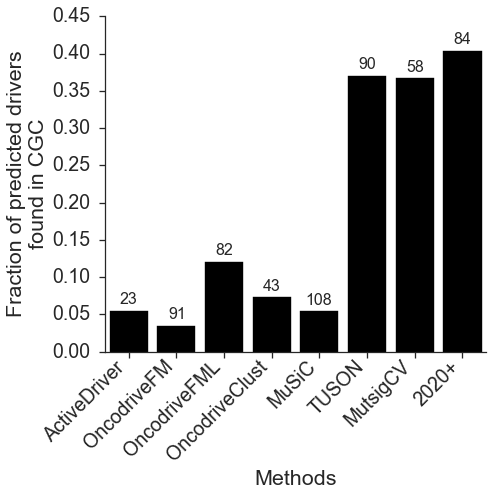

In [14]:
def plot_cgc_overlap(cgc_overlap_df, list_name='CGC', custom_order=None):
    """Create a bar plot for the fraction overlap with the cancer gene census (CGC).
    
    Parameters
    ----------
    cgc_overlap_df : pd.DataFrame
        Dataframe containing method names as an index and columns for '# CGC' and
        'Fraction overlap w/ CGC'
    custom_order : list or None
        Order in which the methods will appear on the bar plot
    """
    # Function to label bars
    def autolabel(rects):
        # attach some text labels
        for ii, rect in enumerate(rects):
            height = rect.get_height()
            plt.text(rect.get_x()+rect.get_width()/2., height+.005, '%s' % (name[ii]),
                     ha='center', va='bottom', size=16)

    # order methods if no order given
    if custom_order is None:
        custom_order = cgc_overlap_df.sort_values('Fraction overlap w/ {0}'.format(list_name)).index.tolist()
            
    # make barplot
    name = cgc_overlap_df.ix[custom_order]['# '+list_name].tolist()
    with sns.axes_style('ticks'), sns.plotting_context('talk', font_scale=1.5):
        ax = sns.barplot(cgc_overlap_df.index,
                         cgc_overlap_df['Fraction overlap w/ {0}'.format(list_name)],
                         order=custom_order, color='black')

        # label each bar
        autolabel(ax.patches)

        # fiddle with formatting
        ax.set_xlabel('Methods')
        ax.set_ylabel('Fraction of predicted drivers\nfound in '+list_name)
        sns.despine()
        plt.xticks(rotation=45, ha='right', va='top')
        plt.gcf().set_size_inches(7, 7)
        # change tick padding
        plt.gca().tick_params(axis='x', which='major', pad=0)

    # format layout
    plt.tight_layout()

# make bar plot
order = ['ActiveDriver', 'OncodriveFM', 'OncodriveFML', 
         'OncodriveClust', 'MuSiC', 'TUSON', 'MutsigCV', '2020+']
plot_cgc_overlap(overlap_df, custom_order=order)